# Computing metadata for pavement cells

Given a 2D image of pavement cells, we can filter it by cell area or convexity and compute a persistence diagram to topologically describe the pattern. 

Relevant literature:

- M. Feng and M. Porter (2021) **Persistent Homology of Geospatial Data: A Case Study with Voting**. [DOI: 10.1137/19M1241519](https://doi.org/10.1137/19M1241519)
- FK. Clark, G. Weissbart, X. Wang, K. Harline, C-B. Li, P. Formosa-Jordan, AHK Roeder (2024) **A common pathway controls cell size in the sepal and leaf epidermis leading to a non-random pattern of giant cells.** [DOI: 10.1101/2024.07.26.605215](https://doi.org/10.1101/2024.07.26.605215)

## The script

- Load necessary packages. 

Just the basics are necessary. `json`, `os` and `glob` come by default. `Numpy`, `scipy`, `matplotlib`, and `pandas` are pretty standard.

I like `tifffile` to load TIFF images, but other options may be available. 


In [1]:
import glob
import os
import json
import tifffile as tf
import numpy as np
import pandas as pd
from scipy import ndimage, stats, spatial

import matplotlib.pyplot as plt

## Load the data from a source directory `src`

- All the data files are insidea a `data` directory
- Each tissue/variant is its own folder
- We do `glob.glob` to get automatically the name of all the folders
- For example, the 3rd source folder `sidx = 3` corresponds to `../results/sepal/`

### Define a destination directory `dst`

- For consistency, the `results` folder should have the same structure as the `data` one.
- If the folder, say `../results/sepal/` is not existent, we can make it automatically

In [2]:
filesrcs = sorted(glob.glob(os.pardir + os.sep + 'data' + os.sep + '*' + os.sep))
filesrcs

['../data/leaf_25d_WT2/',
 '../data/leaf_25d_WT4/',
 '../data/leaf_25d_WT4_random/',
 '../data/sepal/',
 '../data/sepal_random/']

In [3]:
sidx = 1

src = filesrcs[sidx]
dst = os.pardir + os.sep + 'results' + os.sep + os.path.dirname(src).split(os.sep)[-1] + os.sep
print(dst)
if not os.path.isdir(dst):
    os.makedirs(dst)

../results/leaf_25d_WT4/


## Load the data

- Make a list of all the `.tiff` and `.tif` files inside the source folder.
- This is convenient for the random folders that contain several images

In [4]:
tifffiles = sorted(glob.glob(src + '*.tif*'))
print(tifffiles)

tidx = 0
tifffile = tifffiles[tidx]
_,filename = os.path.split(tifffile)
bname, _ = os.path.splitext(filename)
print(tidx, filename, bname, sep='\t')

['../data/leaf_25d_WT4/segmentation.tiff']
0	segmentation.tiff	segmentation


- Load a single image
- Get the center of mass for each cell with `ndimage.center_of_mass`
- Get bounding boxes for every cell with `ndimage.find_objects`
- Optional: Visualize it with `imshow`

In [5]:
img = tf.imread(tifffile)
print(filename, img.min(), img.max(), img.shape, img.dtype, sep='\t')
coms = np.asarray(ndimage.center_of_mass(img, img, range(img.min(), img.max()+1)))
css = ndimage.find_objects(img)

segmentation.tiff	1	638	(2886, 3013)	uint16


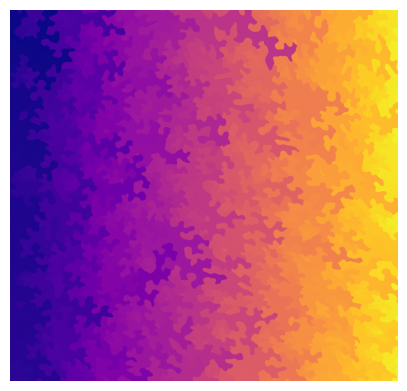

In [51]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.imshow(img, cmap='plasma')
ax.axis('off');

In [5]:
# Auxiliary variables so they are not computed over and over again

pad = 2
xy1 = np.array([0.5,-0.5]).reshape(-1,1)
xy2 = np.array([-0.5,0.5]).reshape(-1,1)
bordermask = ndimage.generate_binary_structure(2,1).astype(int)
bordermask[1,1] = -bordermask.sum() + 1

- For each cell, find its border
- Compute its perimeter and area
- Get the convex hull and compare it to the original perimeter and area to compute convexity ratios

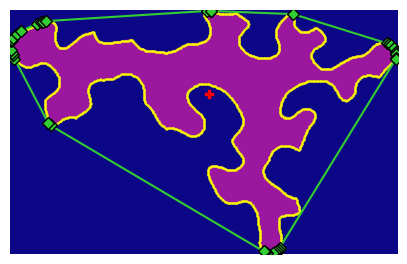

In [57]:
# Cell index/label/color
idx = 314

# Bounding box: add some padding on the sides for better visualization
s_ = (np.s_[max(0, css[idx][0].start - pad) : min(img.shape[0], css[idx][0].stop + pad)] , 
      np.s_[max(0, css[idx][1].start - pad) : min(img.shape[1], css[idx][1].stop + pad)])
extent = (s_[1].start, s_[1].stop, s_[0].stop, s_[0].start)

# Make a new binary image: only highlight the chosen cell and make zero elsewhere
cell = img[s_] == idx + 1

# Compute the border of the cell
nzborder = ndimage.convolve(cell.astype(int), bordermask, mode='constant', cval=0)

# Compute the perimeter
label, n = ndimage.label(nzborder < 0, ndimage.generate_binary_structure(2,1))
hist, _ = np.histogram(label, range(1, n+2))
perimeter = np.sum(hist - 1) + n*np.sqrt(2)

# Get the pixel coordinates of the border
border = np.asarray(np.nonzero(nzborder < 0)).astype(float)
chborder = np.hstack((border + 0.5, border - 0.5, border + xy1, border + xy2))

# Compute the convex hull of the cell
convexhull = spatial.ConvexHull(np.flip(chborder).T)
hull = convexhull.points[convexhull.vertices]
hull = np.vstack( (hull, hull[0])).T

# Visualize the results
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.imshow(cell, cmap='plasma', origin='upper', vmin=0, vmax=3)
ax.scatter(coms[idx,1] - extent[0], coms[idx, 0] - extent[3], c='r', marker='P', s=30)
ax.scatter(border[1], border[0] , c='yellow', marker='.', s=1)
ax.plot(hull[0], hull[1] , c='limegreen', marker='D', mec='k')
ax.axis('off');

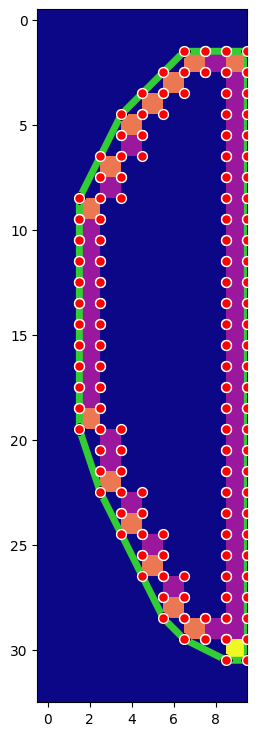

In [56]:
# Highlighting in red circles the point-coordinates considered when computing the convex hull
# The convex hull wraps around the full pixel

fig, ax = plt.subplots(1,1, figsize=(9,9))
ax.imshow(label, cmap='plasma', origin='upper', vmin=0)
ax.imshow(nzborder, cmap='plasma_r', origin='upper', vmax=0)
ax.scatter(chborder[1], chborder[0], c='red', marker='o', s=50, ec='w', zorder=5)
ax.plot(hull[0], hull[1], c='limegreen', marker='D', mec='k', lw=5);

## Make it a loop

- Put the above code inside a loop to compute values for all the cells
- Store the results in a DataFrame
- This DataFrame is then saved as a CSV file `_metadata.csv` in the same directory where the TIFFs are located.
- The loop only runs once: after that, it will simply load the pre-computed CSV to save time

In [6]:
datafile = src + bname + '_metadata.csv'

if not os.path.isfile(datafile):
    pad = 2
    xy1 = np.array([0.5,-0.5]).reshape(-1,1)
    xy2 = np.array([-0.5,0.5]).reshape(-1,1)
    
    columns = ['centerX', 'centerY', 'perimeter', 'area', 'ch_perimeter', 'ch_area', 'pconvexity', 'aconvexity']
    data = pd.DataFrame(0., index=range(1, len(css)+1), columns=columns)
    
    for idx in range(len(data)):
        
        s_ = (np.s_[max(0, css[idx][0].start - pad) : min(img.shape[0], css[idx][0].stop + pad)] , 
              np.s_[max(0, css[idx][1].start - pad) : min(img.shape[1], css[idx][1].stop + pad)])
        cell = img[s_] == idx + 1
        area = cell.sum()
        
        nzborder = ndimage.convolve(cell.astype(int), bordermask, mode='constant', cval=0) < 0
        
        label, n = ndimage.label(nzborder, ndimage.generate_binary_structure(2,1))
        hist, _ = np.histogram(label, range(1, n+2))
        perimeter = np.sum(hist - 1) + n*np.sqrt(2)
    
        border = np.asarray(np.nonzero(nzborder)).astype(float)
        chborder = np.hstack((border + 0.5, border - 0.5, border + xy1, border + xy2))
        convexhull = spatial.ConvexHull(np.flip(chborder).T)
        
        data.loc[idx + 1] = [coms[idx,1], coms[idx,0], perimeter, area, 
                             convexhull.area, convexhull.volume, convexhull.area/perimeter, area/convexhull.volume] 
    data = data.astype({'area':int})
    data.to_csv(datafile, index=True, index_label='Label')

data = pd.read_csv(datafile).set_index('Label')
print(data.shape)
data.head()

(638, 8)


,centerX,centerY,perimeter,area,ch_perimeter,ch_area,pconvexity,aconvexity
Label,,,,,,,,
1,61.373869,58.106198,580.546248,11940,470.552743,15041.0,0.810534,0.793830
2,18.980871,142.452079,408.048773,5123,366.442229,6587.5,0.898035,0.777685
3,232.277407,211.739969,2325.228714,50817,1257.422040,104085.0,0.540773,0.488226
4,26.463696,290.688065,260.894444,3209,236.955745,3862.5,0.908244,0.830809
5,250.284159,411.948938,2834.414572,64960,1388.076410,122924.5,0.489722,0.528454


## Get neighbors

- Make a JSON file listing all the neighbors for every cell `_neighbors.json`
- The keys are all the cell labels
- For each key, a list with neighbor labels is given
- Two cells are neighbors if they touch in at least one pixel
- The resulting JSON is stored in the same directory as the rest of TIFFs

In [74]:
datafile = src + bname + '_neighbors.json'

if not os.path.isfile(datafile):
    neighbors = dict()
    pad = 2
    for idx in range(len(css)):
        s_ = (np.s_[max(0, css[idx][0].start - pad) : min(img.shape[0], css[idx][0].stop + pad)] , 
              np.s_[max(0, css[idx][1].start - pad) : min(img.shape[1], css[idx][1].stop + pad)])
        cell = img[s_] == idx + 1
        
        nzborder = ndimage.convolve(cell.astype(int), bordermask, mode='constant', cval=0) > 0
        neighbors[idx + 1] = np.unique(img[s_][nzborder]).tolist()
    with open(datafile, 'w') as f:
        json.dump(neighbors, f, indent=1, separators=(',', ':'))

with open(datafile, "r") as f:
    neigbors = json.load(f)

----

# Next Notebooks

- New notebooks should focus on computing persistence diagrams using various filtrations